# Cox time-varying proportional hazards model with hyperparameter tuning

In [1]:
import sys
import logging
from pathlib import Path
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

from hyperopt import hp
import pandas as pd
from prefect import Flow, unmapped

from nbaspa.model.tasks import (
    SurvivalData,
    SegmentData,
    InitializeLifelines,
    FitLifelinesModel,
    CollapseData,
    PredictLifelines,
    WinProbability,
    PlotProbability,
    ConcordanceIndex,
    AUROC,
    PlotMetric,
    LifelinesTuning,
    PlotTuning
)
from nbaspa.model.tasks.meta import META

# Suppress the SettingWithCopyWarning for logging clarity
pd.options.mode.chained_assignment = None  # default='warn'

## Load the data

In [2]:
df = pd.concat(
    pd.read_csv(fpath, sep="|", dtype={"GAME_ID": str}, index_col=0)
    for fpath in Path("..", "nba-data", "2018-19", "model-data").glob("data_*.csv")
).reset_index(drop=True)

In [3]:
df[
    [META["id"]] + META["dynamic"] + META["static"]
].head(n=5)

,GAME_ID,SCOREMARGIN,HOME_LINEUP_PLUS_MINUS,VISITOR_LINEUP_PLUS_MINUS,HOME_NET_RATING,VISITOR_NET_RATING,HOME_W_PCT,VISITOR_W_PCT,LAST_GAME_WIN,HOME_GAMES_IN_LAST_3_DAYS,HOME_GAMES_IN_LAST_5_DAYS,HOME_GAMES_IN_LAST_7_DAYS,VISITOR_GAMES_IN_LAST_3_DAYS,VISITOR_GAMES_IN_LAST_5_DAYS,VISITOR_GAMES_IN_LAST_7_DAYS
0,0021800001,0,0.1,-0.1,5.1,3.3,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
1,0021800001,0,0.1,-0.1,5.1,3.3,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
2,0021800001,0,0.1,-0.1,5.1,3.3,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
3,0021800001,0,0.1,-0.1,5.1,3.3,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
4,0021800001,0,0.1,-0.1,5.1,3.3,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0


## Build the model with hyperparameter tuning

We'll use a $Unif(0, 1)$ distribution for both the `penalizer` and the `l1_ratio`. We will tune the model with 100 ``hyperopt`` iterations.

In [4]:
# Initial formatting and segmentation
format_data = SurvivalData(name="Convert input data to range form")
segdata = SegmentData(name="Split data")
# Collapsing data
tune_data = CollapseData(name="Create tuning data")
test_benchmark = CollapseData(name="Create final test data")
test_data = CollapseData(name="Create metric test data")
# Model tuning
tuning = LifelinesTuning(name="Hyperparameter tuning")
tuning_plots = PlotTuning(name="Hyperparameter plotting")
# Model training
model = InitializeLifelines(name="Initialize Cox model")
trained = FitLifelinesModel(name="Fit Cox model")
# Prediction and metrics
hazpred = PredictLifelines(name="Predict partial hazard function")
concord = ConcordanceIndex(name="Calculate Concordance index")
survpredict = WinProbability(name="Predict win probability")
predict = WinProbability(name="Predict win probability")
auroc = AUROC(name="Calculate AUROC")
metricplot = PlotMetric(name="Plot Concordance")
probplot = PlotProbability(name="Plot the survival probability")

times = [0, 720, 1440, 2160, 2880]

In [5]:
with Flow(name="My model pipeline") as flow:
    # Format and segment the data into train, tune, test
    alldata = format_data(df)
    data = segdata(alldata, splits=[0.6, 0.25], keys=["train", "tune", "test"])
    # Collapse the test and tune data to the final row so we can accurately calculate Concordance
    tune = tune_data(data["tune"])
    test_lr = test_benchmark(data["test"])
    # Create test data for time steps at the start of the game, end of 1st, etc.
    test = test_data.map(data=unmapped(data["test"]), timestep=times)
    # Hyperparameter tuning (with plots)
    params = tuning(data["train"], tune)
    tuning = tuning_plots(params["trials"])
    # Fit the final model from hyperparameter tuning
    model_obj = model(params["best"])
    fitted = trained(model=model_obj, data=data["train"])
    # Get the final Concordance index
    predt = hazpred(model=fitted, data=test_lr)
    cind = concord(data=test_lr, predt=predt)
    # Predict the survival probability at start of game, end of 1st, etc.
    surv = predict.map(model=unmapped(fitted), data=test)
    # Get the AUROC based on survival probability for each time step and plot
    metric = auroc.map(data=surv)
    plots = metricplot(times=times, metric="AUROC", survival=metric)
    # Plot the final survival probability against the margin of the game
    survpred = survpredict(model=fitted, data=test_lr)
    prob = probplot(data=survpred)

[2021-02-14 11:53:49+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'My model pipeline'
[2021-02-14 11:53:49+0000] INFO - prefect.TaskRunner | Task 'Convert input data to range form': Starting task run...
[2021-02-14 11:54:14+0000] INFO - prefect.TaskRunner | Task 'Convert input data to range form': Finished task run for task with final state: 'Success'
[2021-02-14 11:54:14+0000] INFO - prefect.TaskRunner | Task 'Split data': Starting task run...
[2021-02-14 11:54:14+0000] INFO - prefect.Split data | Setting the seed to 42
[2021-02-14 11:54:14+0000] INFO - prefect.Split data | Dataset ``train`` has 737 games with 84607 rows
[2021-02-14 11:54:14+0000] INFO - prefect.Split data | Dataset ``tune`` has 307 games with 35766 rows
[2021-02-14 11:54:15+0000] INFO - prefect.Split data | Dataset ``test`` has 185 games with 20939 rows
[2021-02-14 11:54:15+0000] INFO - prefect.TaskRunner | Task 'Split data': Finished task run for task with final state: 'Success'
[2021-02-14 11:54:15+0000

<lifelines.CoxTimeVaryingFitter: fitted with 84607 periods, 737 subjects, 442 events>
         event col = 'WIN'
         penalizer = 0.37941038474224864
number of subjects = 737
 number of periods = 84607
  number of events = 442
partial log-likelihood = -2652.16
  time fit was run = 2021-02-14 12:00:51 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                            
HOME_GAMES_IN_LAST_3_DAYS     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
HOME_GAMES_IN_LAST_5_DAYS     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
HOME_GAMES_IN_LAST_7_DAYS     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
HOME_LINEUP_PLUS_MINUS         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
HOME_NET_RATING                0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
HOME_W_PCT                     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
LAST_GAME_WIN                  0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
SCOREMARGIN                    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
VISITOR_GAMES_IN_LAST_3_DAYS   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
VISITOR_GAMES_IN_LAST_5_DAYS   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
VISITOR_GAMES_IN_LAST_7_DAYS   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
VISITOR_LINEUP_PLUS_MINUS     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
VISITOR_NET_RATING            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
VISITOR_W_PCT                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                                 z    p   -log2(p)
covariate                                         
HOME_GAMES_IN_LAST_3_DAYS    -0.00 1.00       0.00
HOME_GAMES_IN_LAST_5_DAYS    -0.00 1.00       0.00
HOME_GAMES_IN_LAST_7_DAYS    -0.00 1.00       0.00
HOME_LINEUP_PLUS_MINUS        0.01 0.99       0.02
HOME_NET_RATING               0.03 0.98       0.03
HOME_W_PCT                    0.02 0.98       0.02
LAST_GAME_WIN                 0.01 0.99       0.01
SCOREMARGIN                   1.78 0.07       3.75
VISITOR_GAMES_IN_LAST_3_DAYS  0.01 1.00       0.01
VISITOR_GAMES_IN_LAST_5_DAYS  0.00 1.00       0.00
VISITOR_GAMES_IN_LAST_7_DAYS  0.01 0.99       0.01
VISITOR_LINEUP_PLUS_MINUS    -0.01 0.99       0.02
VISITOR_NET_RATING           -0.02 0.98       0.03
VISITOR_W_PCT                -0.02 0.99       0.02
---
Partial AIC = 5332.32
log-likelihood ratio test = 3.13 on 14 df
-log2(p) of ll-ratio test = 0.00

[2021-02-14 12:00:54+0000] INFO - prefect.TaskRunner | Task 'Fit Cox model': Finished task run for task with final state: 'Success'
[2021-02-14 12:00:54+0000] INFO - prefect.TaskRunner | Task 'Predict partial hazard function': Starting task run...
[2021-02-14 12:00:54+0000] INFO - prefect.TaskRunner | Task 'Predict partial hazard function': Finished task run for task with final state: 'Success'
[2021-02-14 12:00:54+0000] INFO - prefect.TaskRunner | Task 'Hyperparameter plotting': Starting task run...
[2021-02-14 12:00:55+0000] INFO - prefect.TaskRunner | Task 'Hyperparameter plotting': Finished task run for task with final state: 'Success'
[2021-02-14 12:00:55+0000] INFO - prefect.TaskRunner | Task 'Predict win probability': Starting task run...
[2021-02-14 12:00:55+0000] INFO - prefect.TaskRunner | Task 'Predict win probability': Finished task run for task with final state: 'Mapped'
[2021-02-14 12:00:55+0000] INFO - prefect.TaskRunner | Task 'Predict win probability[0]': Starting task

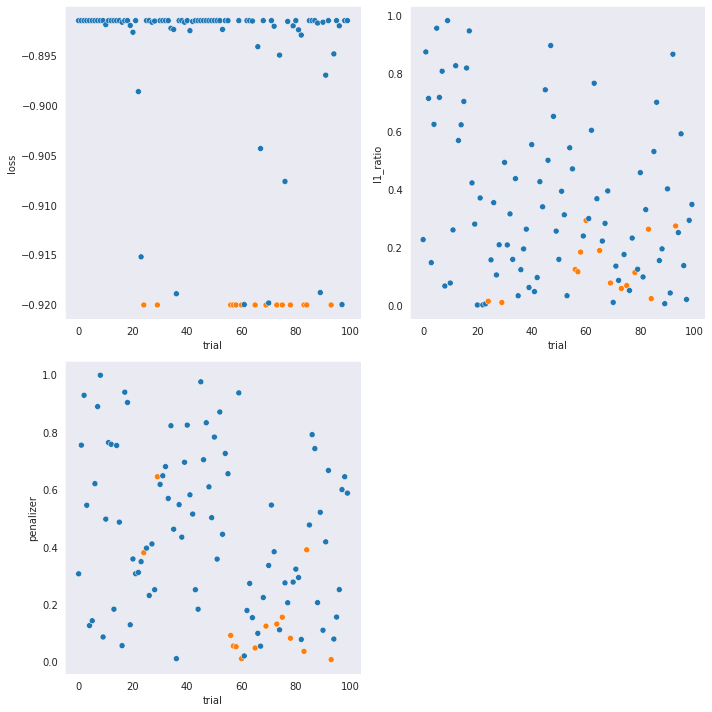

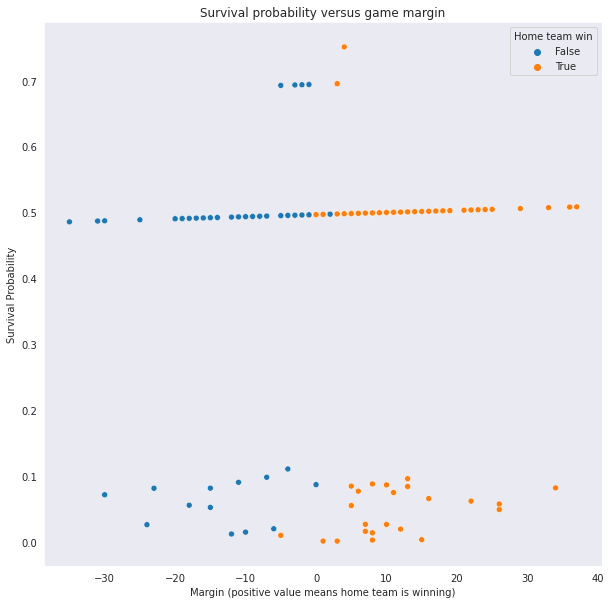

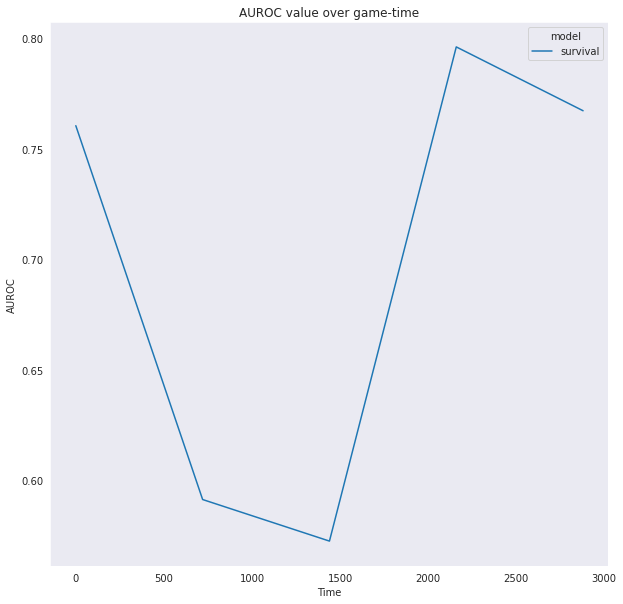

In [6]:
output = flow.run()